# Infilling

In this notebook we demonstrate Silicone's infilling methods.

## Imports

In [1]:
# NBVAL_IGNORE_OUTPUT
import os.path
import traceback

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.database_crunchers

<IPython.core.display.Javascript object>

## Constants

In [2]:
SR15_SCENARIOS = "./sr15_scenarios.csv"

## Example data

Here we pull some example data by downloading a selection of the SR1.5 scenarios.

In [3]:
def get_sr15_scenarios(output_file):
    conn = pyam.iiasa.Connection("iamc15")
    valid_model_ids = [
        "MESSAGE*",
        "AIM*",
        "C-ROADS*",
        "GCAM*",
        #"IEA*",
        #"IMAGE*",
        #"MERGE*",
        #"POLES*",
        #"REMIND*",
        "WITCH*"
    ]
    variables_to_fetch = [
        "Emissions*",
    ]
    for model in valid_model_ids:
        print("Fetching data for {}".format(model))
        for variable in variables_to_fetch:
            print("Fetching {}".format(variable))
            var_df = conn.query(model=model, variable=variable, region='World')
            try:
                df.append(var_df, inplace=True)
            except NameError:
                df = pyam.IamDataFrame(var_df)

    print("Writing to {}".format(output_file))
    df.to_csv(output_file)

In [4]:
# NBVAL_IGNORE_OUTPUT
if not os.path.isfile(SR15_SCENARIOS):
    get_sr15_scenarios(SR15_SCENARIOS)

### Starting point

Our starting point is the test data, loaded a `pyam.IamDataFrame`.

In [5]:
# NBVAL_IGNORE_OUTPUT
sr15_data = pyam.IamDataFrame(SR15_SCENARIOS)
sr15_data.timeseries().head()

INFO:root:Reading `./sr15_scenarios.csv`


2000  \
model       scenario               region variable                                           unit      meta subannual         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0         NaN   
                                          Emissions|CH4                                      Mt CH4/yr 0    0.0         NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0    0.0         NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0    0.0         NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0    0.0         NaN   

                                                                                                                           2005  \
model       scenario               region variable                                           unit      meta subannual             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0          8.3367   
                                          Emissions|CH4                                      Mt CH4/yr 0    0.0        344.9167   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0    0.0        167.6717   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0    0.0          0.4732   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0    0.0         11.2639   

                                                                                                                           2010  \
model       scenario               region variable                                           unit      meta subannual             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0          7.6408   
                                          Emissions|CH4                                      Mt CH4/yr 0    0.0        367.7457   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0    0.0        179.6356   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0    0.0          0.5168   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0    0.0         11.1249   

                                                                                                                           2015  \
model       scenario               region variable                                           unit      meta subannual             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0          7.2724   
                                          Emissions|CH4                                      Mt CH4/yr 0    0.0        380.4086   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0    0.0        190.3513   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0    0.0          0.5587   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0    0.0         10.9809   

                                                                                                                           2020  \
model       scenario               region variable                                           unit      meta subannual             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0    0.0          7.0752   
                                          Emissions|CH4                           

## Crunchers

Silicone's 'crunchers' are used to determine the relationship between a 'follower variable' and 'lead variable(s)' from a given database. The 'follower variable' is the variable for which we want to generate data e.g. `Emissions|C3F8` while the 'lead variable(s)' is the variable we want to use in order to infer a timeseries of the 'follower variable'. The lead variable is typically CO$_2$ but might be a more complex combination of gases e.g. CO$_2$, CH$_4$ and N$_2$O. 

Each cruncher has a `derive_relationship` method. Its docstring describes what it does.

In [6]:
print(silicone.database_crunchers.base._DatabaseCruncher.derive_relationship.__doc__)
# # an alternative interface is shown if you use the line below instead
# silicone.database_crunchers.base._DatabaseCruncher.derive_relationship?


        Derive the relationship between two variables from the database

        Parameters
        ----------
        variable_follower : str
            The variable for which we want to calculate timeseries (e.g.
            ``"Emissions|C5F12"``).

        variable_leaders : list[str]
            The variables we want to use in order to infer timeseries of
            ``variable_follower`` (e.g. ``["Emissions|CO2", "Emissions|CH4"]``)

        **kwargs
            Keyword arguments used by this class to derive the relationship between
            ``variable_follower`` and ``variable_leaders``.

        Returns
        -------
        :obj:`func`
            Function which takes a :obj:`pyam.IamDataFrame` containing
            ``variable_leaders`` timeseries and returns timeseries for
            ``variable_follower`` based on the derived relationship between the two.
            Please see the source code for the exact definition (and docstring) of the
            returned functi

These crunchers are best explored by looking at the examples below.

### Closest RMS cruncher

This cruncher uses the 'closest RMS' methodology. It is described by its docstring.

In [7]:
print(silicone.database_crunchers.DatabaseCruncherRMSClosest.__doc__)
# silicone.database_crunchers.DatabaseCruncherRMSClosest?


    Database cruncher which uses the 'closest RMS' technkque.

    This cruncher derives the relationship between two variables by finding the
    scenario which has the closest lead gas timeseries in the database.  The follower
    gas timeseries is then simply copied from the closest scenario.

    Here, 'closest' is defined as the smallest time-averaged root mean squared (L2)
    difference.

    .. math::
        RMS = \left ( \frac{1}{n} \sum_{t=0}^n (E_l(t) - E_l^{d}(t))^2 \right )^{1/2}

    where :math:`n` is the total number of timesteps in the lead gas' timeseries,
    :math:`E_l(t)` is the lead gas emissions timeseries and :math:`E_l^d(t)` is a lead
    gas emissions timeseries in the database.
    


#### Infilling

Firstly, let's cut the database down to a size that is comprehensible.

In [8]:
# NBVAL_IGNORE_OUTPUT
sr15_data_closest_rms = sr15_data.filter(model=["WITCH-GLOBIOM 4.2"])

Now we can crunch the relationship between e.g. `Emissions|CO2` and `Emissions|VOC`.

In [9]:
# NBVAL_IGNORE_OUTPUT
cruncher = silicone.database_crunchers.DatabaseCruncherRMSClosest(sr15_data_closest_rms)

In [10]:
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)
# filler info:


            Filler function derived from :obj:`DatabaseCruncherRMSClosest`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                If there are any inconsistencies between the timeseries, units or
                expectations of the program and ``in_iamdf``, compared to the database
                used to generate this ``filler`` function.
            


Now we can do some infilling. As a sanity check, we firstly make sure that if we pass in a CO$_2$ timeseries which is already in the database, we get back its VOC emissions timeseries. 

In [11]:
example_model_scen = {
    "model": "WITCH-GLOBIOM 4.2",
    "scenario": "ADVANCE_INDC",
}
example_input = sr15_data_closest_rms.filter(**example_model_scen).data
example_input["model"] = "example"
example_input["scenario"] = "example"
example_input = pyam.IamDataFrame(example_input)

In [12]:
# NBVAL_IGNORE_OUTPUT
example_input_filled = filler(example_input)

In [13]:
#NBVAL_IGNORE_OUTPUT
example_input_filled.timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,,,,,,,,,,
example,example,World,Emissions|VOC,Mt VOC/yr,0,0.0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,102.038923,89.302542,76.60488,62.855685,58.440154,56.971497,55.075327,53.101911,51.074418,49.558506,47.602518,45.377459,43.08547,41.400122


In [14]:
#NBVAL_IGNORE_OUTPUT
sr15_data_closest_rms.filter(variable="Emissions|VOC", **example_model_scen).timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,,,,,,,,,,
WITCH-GLOBIOM 4.2,ADVANCE_INDC,World,Emissions|VOC,Mt VOC/yr,0,0.0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,102.038923,89.302542,76.60488,62.855685,58.440154,56.971497,55.075327,53.101911,51.074418,49.558506,47.602518,45.377459,43.08547,41.400122


As expected, the cruncher has picked out the scenario which matches and returned its VOC timeseries. This can also be seen in a plot.

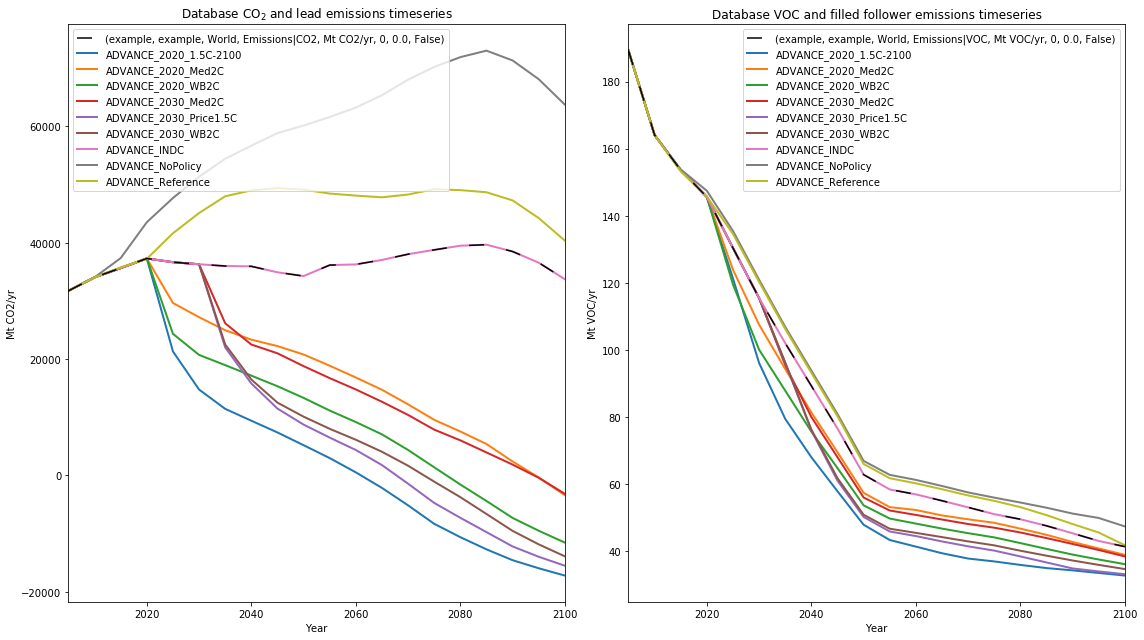

In [15]:
# NBVAL_IGNORE_OUTPUT
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_closest_rms.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
# sr15_data_closest_rms.filter(variable="*CO2", **example_model_scen).line_plot(ax=ax, color="black")
example_input.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_closest_rms.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
example_input_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

Now we can use our filler to infill other timeseries.

In [16]:
filler_input = sr15_data.filter(model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600")

This scenario is missing `Emissions|VOC`.

In [17]:
#NBVAL_IGNORE_OUTPUT
filler_input.filter(variable="Emissions|VOC").data

,model,scenario,region,variable,unit,year,meta,subannual,value


In [18]:
filler_input_filled = filler(filler_input)

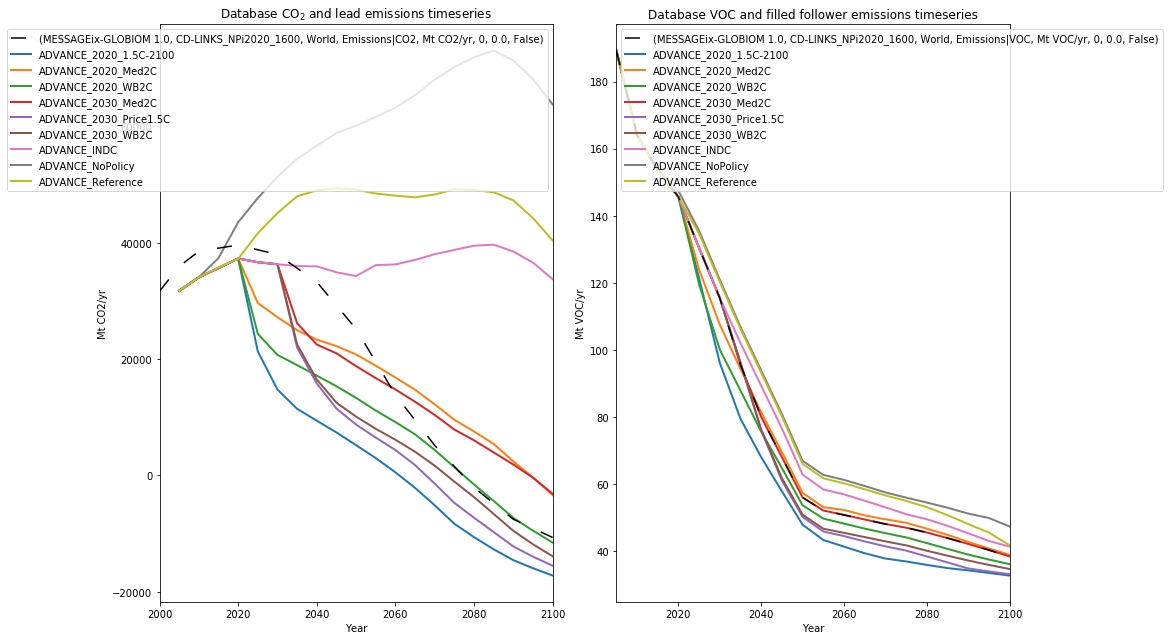

In [19]:
# NBVAL_IGNORE_OUTPUT
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_closest_rms.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
# sr15_data_closest_rms.filter(variable="*CO2", **example_model_scen).line_plot(ax=ax, color="black")
filler_input.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_closest_rms.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
filler_input_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

As we can see, on an RMS basis our input timeseries is closest to the 'ADVANCE_2030_Med2C' scenario and hence its `Emissions|VOC` pathway is returned.

In [20]:
#NBVAL_IGNORE_OUTPUT
filler_input_filled.timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,,,,,,,,,,
MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,0,0.0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,95.506957,80.043895,68.04429,56.038428,52.164286,50.849028,49.479184,48.134296,47.046133,45.615107,43.948576,42.192038,40.390822,38.480263


In [21]:
#NBVAL_IGNORE_OUTPUT
sr15_data_closest_rms.filter(scenario="ADVANCE_2030_Med2C", variable="Emissions|VOC").timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,,,,,,,,,,
WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,0,0.0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,95.506957,80.043895,68.04429,56.038428,52.164286,50.849028,49.479184,48.134296,47.046133,45.615107,43.948576,42.192038,40.390822,38.480263


### Rolling Window Quantile cruncher

This cruncher uses the 'rolling window quantile' methodology. It is described by its docstring.

In [22]:
print(silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows.__doc__)
# silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows?


    Database cruncher which uses the 'rolling windows' technique.

    This cruncher derives the relationship between two variables by performing
    quantile calculations between the follower timeseries and the lead timeseries.
    These calculations are performed at each timestep in the timeseries, independent
    of the other timesteps.

    For each timestep, the lead timeseries axis is divided into multiple evenly spaced
    windows (to date this is only tested on 1:1 relationships but may work with more
    than one lead timeseries). In each window, every data point in the database is
    included. However, the data points receive a weight given by

    .. math::

        w(x, x_{\text{window}}) = \frac{1}{1 + (d_n)^2}

    where :math:`w` is the weight and :math:`d_n` is the normalised distance between
    the centre of the window and the data point's position on the lead timeseries axis.

    :math:`d_n` is calculated as

    .. math::

        d_n = \frac{x - x_{\text{window}

#### Infilling

Because it relies on quantile analysis, this database does best with large amounts of data. Hence we keep quite a lot of emissions timeseries before beginning.

In [23]:
sr15_data_quantile = sr15_data.copy().filter(
    model=["WITCH-GLOBIOM 4.2"], variable=["Emissions|CO2", "Emissions|VOC"]
)

In [24]:
cruncher = silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows(sr15_data_quantile)

In [25]:
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)
# filler?


            Filler function derived from :obj:`DatabaseCruncherQuantileRollingWindows`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                The key db_times for filling are not in ``in_iamdf``.
            


Now we can infill.

In [26]:
filler_data = sr15_data.filter(
    model="MESSAGEix-GLOBIOM 1.0", 
    scenario="CD-LINKS_NPi2020_1600", 
    variable=["Emissions|CO2"]
)

The `filler_data` is missing `Emissions|VOC`.

In [27]:
#NBVAL_IGNORE_OUTPUT
filler_data.filter(variable="Emissions|VOC").data

,model,scenario,region,variable,unit,year,meta,subannual,value


The rolling windows quantile can only downscale on the timesteps in the database. If this isn't the case, we will receive a `ValueError`.

In [28]:
try:
    filler(filler_data)
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: Not all required timepoints are present in the database we crunched, we crunched 
	`[2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]`
but you passed in 
	[2000, 2005, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]


We can fix this by filtering first.

In [29]:
# NBVAL_IGNORE_OUTPUT
filler_data = filler_data.filter(year=sr15_data_quantile["year"].unique())

In [30]:
#NBVAL_IGNORE_OUTPUT
filler_data.timeseries()

,,,,,,,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
model,scenario,region,variable,unit,meta,subannual,,,,,,,,,,,
MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,0,0.0,35933.0697,38542.01816,39615.22255,37981.07524,33271.92656,25181.95619,13847.19271,5163.226383,-2068.503671,-7525.726077,-10662.64286


In [31]:
#NBVAL_IGNORE_OUTPUT
filler_data_filled = filler(filler_data)
filler_data_filled.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2005,0,0.0,189.212000
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2010,0,0.0,164.056724
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2020,0,0.0,145.611005
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2030,0,0.0,115.465871
4,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2040,0,0.0,89.302542


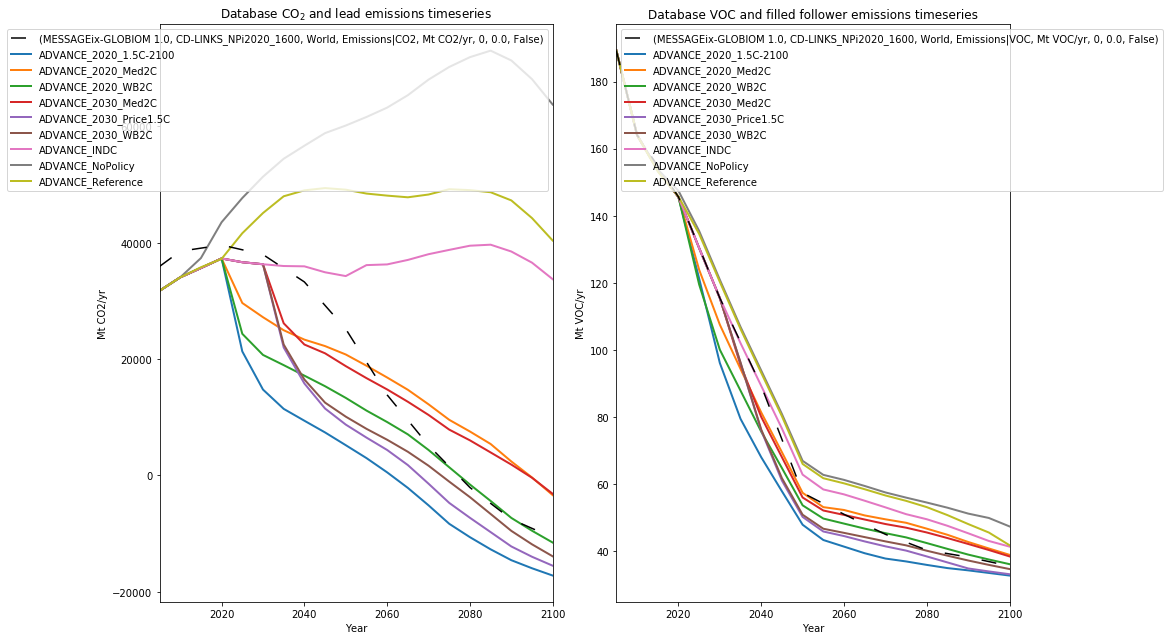

In [32]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
# sr15_data_closest_rms.filter(variable="*CO2", **example_model_scen).line_plot(ax=ax, color="black")
filler_data.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
filler_data_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

#### Recovering the data you put in

Because of the averaging mechanism, the cruncher will only precisely reproduce the input data when only one timeseries is put into it. With multiple data series, this is not guaranteed, although will happen in the limit case of many windows. 

This section does not illustrate new functionality, merely investigates the mathematical effects of changing the number of windows.

In [33]:
# NBVAL_IGNORE_OUTPUT
# Multiple data are input - the 50th percentile and nwindows=10 is the default
filler_data = sr15_data_quantile.filter(scenario='ADVANCE_2030_Med2C')
self_cruncher = silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows(sr15_data)
self_filler_default = self_cruncher.derive_relationship("Emissions|VOC", ["Emissions|VOC"], nwindows=10)
infilled_quantile = self_filler_default(filler_data)
infilled_quantile.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2005,0,0.0,191.049719
1,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2010,0,0.0,159.741053
2,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2015,0,0.0,153.575866
3,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2020,0,0.0,146.071354
4,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2025,0,0.0,130.020399


The default behaviour shows the correct trend, but the windows-based interpolation introduces some noise.

<Figure size 432x432 with 0 Axes>

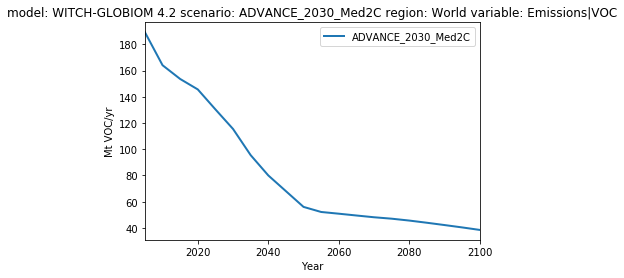

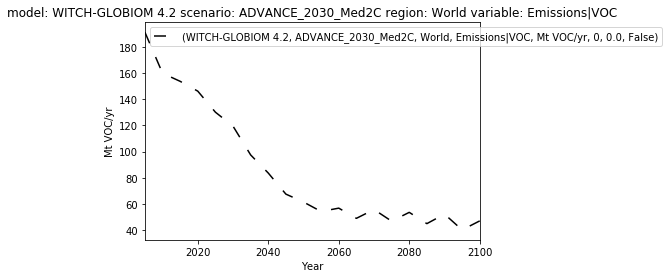

In [34]:
# NBVAL_IGNORE_OUTPUT
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
filler_data.filter(variable='Emissions|VOC', ).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable='Emissions|VOC').line_plot(ax=ax, color="black", linestyle="--", dashes=(8, 10))

By increasing the windows number, we can get a higher fidelity - at the cost of more computational power and less averaging over different datapoints. 

In [35]:
# NBVAL_IGNORE_OUTPUT
# With a lower window number, the deviations become clearer
self_filler_low_w = self_cruncher.derive_relationship("Emissions|VOC", ["Emissions|VOC"], nwindows=2)
infilled_low_w = self_filler_low_w(filler_data)
infilled_low_w.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2005,0,0.0,194.382177
1,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2010,0,0.0,172.149040
2,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2015,0,0.0,176.659563
3,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2020,0,0.0,172.104244
4,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2025,0,0.0,163.986833


In [36]:
# NBVAL_IGNORE_OUTPUT
# Higher window numbers mean that we weight data with the exact same x-value more highly, recovering the original relation
self_filler_high_w = self_cruncher.derive_relationship("Emissions|VOC", ["Emissions|VOC"], nwindows=30)
infilled_high_w = self_filler_high_w(filler_data)
infilled_high_w.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2005,0,0.0,189.332166
1,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2010,0,0.0,164.056724
2,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2015,0,0.0,153.575866
3,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2020,0,0.0,145.809957
4,WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,2025,0,0.0,130.387433


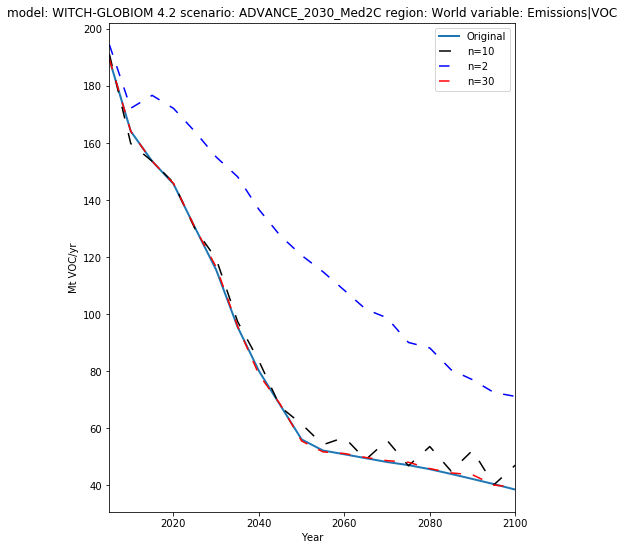

In [37]:
# NBVAL_IGNORE_OUTPUT
# Here the lower window count (orange) results in large deviations whereas the high window case (red) provides a close match. 
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
# This line illustrates the background data informing the deviations (but confuses the plots). 
# Re-add it in place of the legend line if desired
#sr15_data.filter(variable='Emissions|VOC',).line_plot(ax=ax, linewidth=0.1)

filler_data.filter(variable='Emissions|VOC', ).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable='Emissions|VOC').line_plot(ax=ax, color="black", linestyle="--", dashes=(8, 10))
infilled_low_w.line_plot(ax=ax, color="blue", linestyle="--", dashes=(7, 8))
infilled_high_w.line_plot(ax=ax, color="red", linestyle="--", dashes=(7, 8))
plt.legend(['Original', 'n=10', 'n=2', 'n=30'])

### Time-dependent ratio cruncher
This cruncher uses the 'time-dependent ratio' methodology. It is described by its docstring.

In [38]:
print(silicone.database_crunchers.DatabaseCruncherTimeDepRatio.__doc__)


    Database cruncher which uses the 'time-dependent ratio' technique.

    This cruncher derives the relationship between two variables by simply assuming
    that the follower timeseries is equal to the lead timeseries multiplied by a
    time-dependent scaling factor. The scaling factor is the ratio of the
    follower variable to the lead variable. If the database contains many such pairs,
    the scaling factor is the ratio between the means of the values.

    Once the relationship is derived, the 'filler' function will infill following:

    .. math::
        E_f(t) = s(t) * E_l(t)

    where :math:`E_f(t)` is emissions of the follower variable and :math:`E_l(t)` is
    emissions of the lead variable.

    :math:`s(t)` is the scaling factor, calculated as the ratio of the means of the
    the follower and the leader in the cruncher in the database.

    .. math::
        s(t) = \frac{mean( E_f(t) )}{mean( E_l(t) )})

    


#### Infilling
This technique is extracts only a single constant multiplier from all data fed in to the cruncher, so additional data does not radically change how it behaves. We will use the same amount of data as in the previous case for comparison. This cruncher works well for cases like splitting groups of gases into constituent parts, but poorly for gases which may have negative emissions. 

In [39]:
sr15_data_tdr = sr15_data.copy().filter(
    model=["WITCH-GLOBIOM 4.2"], 
    variable=["Emissions|CO2", "Emissions|VOC", "Emissions|CH4" ,"Emissions|HCF*"]
)

In [40]:
cruncher = silicone.database_crunchers.DatabaseCruncherTimeDepRatio(sr15_data_tdr)
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)


            Filler function derived from :obj:`DatabaseCruncherTimeDepRatio`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled-in data (without original source data)

            Raises
            ------
            ValueError
                The key year for filling is not in ``in_iamdf``.
            


In [41]:
# NBVAL_IGNORE_OUTPUT
filler_data = sr15_data.filter(
    model="MESSAGEix-GLOBIOM 1.0", 
    scenario="CD-LINKS_NPi2020_1600", 
    variable=["Emissions|CO2"]
)
filler_data = filler_data.filter(year=sr15_data_quantile["year"].unique())
filler_data.data

,model,scenario,region,variable,unit,year,meta,subannual,value
114115,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2005,0,0.0,35933.069700
114116,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2010,0,0.0,38542.018160
114117,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2020,0,0.0,39615.222550
114118,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2030,0,0.0,37981.075240
114119,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2040,0,0.0,33271.926560
114120,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2050,0,0.0,25181.956190
114121,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2060,0,0.0,13847.192710
114122,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2070,0,0.0,5163.226383
114123,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2080,0,0.0,-2068.503671
114124,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,2090,0,0.0,-7525.726077


In [42]:
# NBVAL_IGNORE_OUTPUT
results= filler(filler_data)
results.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2005,0,0.0,214.182356
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2010,0,0.0,185.661118
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2020,0,0.0,152.067950
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2030,0,0.0,125.620801
4,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2040,0,0.0,99.084653


We observe that the results become anomalous when the lead emissions may be negative:

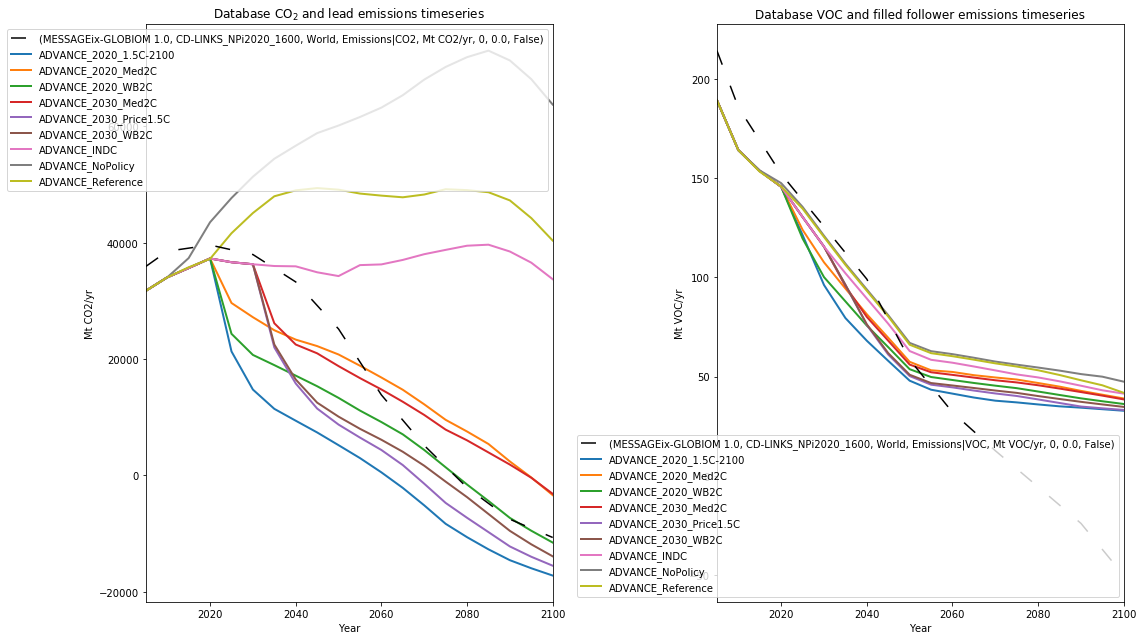

In [43]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_tdr.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_tdr.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
results.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

#### HFC emission splitting
One of the features of the time-dependent ratio is that if the constituent elements consistently add up to a particular value, the infilled results will too, i.e. if for gases A, B, C we have A = B + C in all source material, then this will hold for the infilled values too. This makes it particularly appropriate for splitting gases into their constituents. 

In [44]:
sr15_data_hfc = sr15_data.filter(variable="Emissions|HFC*")
sr15_data_hfc.variables()

0             Emissions|HFC
1      Emissions|HFC|HFC125
2     Emissions|HFC|HFC134a
3     Emissions|HFC|HFC143a
4    Emissions|HFC|HFC227ea
5       Emissions|HFC|HFC23
6       Emissions|HFC|HFC32
7    Emissions|HFC|HFC43-10
8    Emissions|HFC|HFC245fa
Name: variable, dtype: object

In [45]:
# We don't have all variables for all scenarios, but by finding a scenario where we do we can make progress
common_models = set(sr15_data_hfc.filter(variable="Emissions|HFC|HFC245fa").models()).intersection(
    set(sr15_data_hfc.filter(variable="Emissions|HFC").models())
)
common_scenarios = set(sr15_data_hfc.filter(variable="Emissions|HFC|HFC245fa", model=common_models).scenarios()).intersection(
    set(sr15_data_hfc.filter(variable="Emissions|HFC", model=common_models).scenarios())
)
infill_scenarios = "GEA_Eff_1p5C"
#set(sr15_data_hfc.filter(variable="Emissions|HFC").scenarios()) - set(sr15_data_hfc.filter(variable="Emissions|HFC|HFC245fa").scenarios())

infill_models ='MESSAGE V.3' 
# set(sr15_data_hfc.filter(variable="Emissions|HFC").models()) - set(sr15_data_hfc.filter(variable="Emissions|HFC|HFC245fa").models())

infill_scenarios

'GEA_Eff_1p5C'

In [46]:
common_years = np.arange(2010, 2105, 10)
hfc_training_data = sr15_data_hfc.filter(model=common_models, scenario=common_scenarios, year=common_years)
cruncher = silicone.database_crunchers.DatabaseCruncherTimeDepRatio(hfc_training_data)
filler = cruncher.derive_relationship("Emissions|HFC|HFC245fa", ["Emissions|HFC"])

In [47]:
#NBVAL_IGNORE_OUTPUT
to_infill = sr15_data_hfc.filter(model=infill_models, scenario=infill_scenarios, year=common_years)
infilled = filler(to_infill)
infilled.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|HFC|HFC245fa,kt HFC245fa/yr,2010,0,0.0,7.734315
1,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|HFC|HFC245fa,kt HFC245fa/yr,2020,0,0.0,12.652011
2,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|HFC|HFC245fa,kt HFC245fa/yr,2030,0,0.0,9.824725
3,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|HFC|HFC245fa,kt HFC245fa/yr,2040,0,0.0,12.131940
4,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|HFC|HFC245fa,kt HFC245fa/yr,2050,0,0.0,13.848179


INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


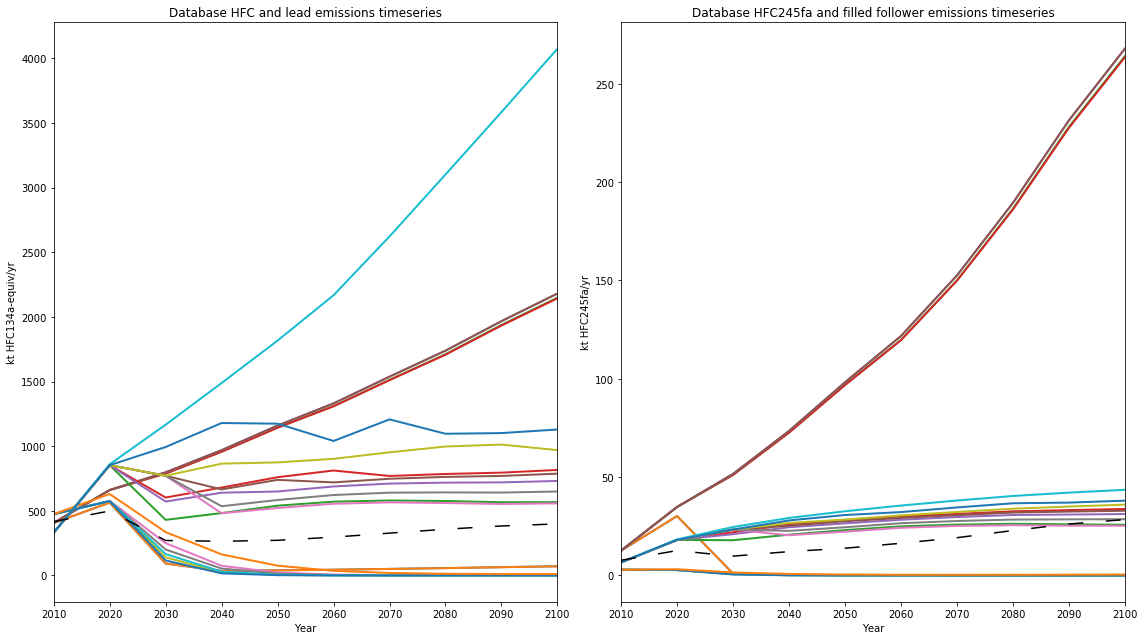

In [48]:
# NBVAL_IGNORE_OUTPUT
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
hfc_training_data.filter(variable="*HFC").line_plot(ax=ax, **pkwargs)
to_infill.filter(variable="*HFC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database HFC and lead emissions timeseries")

ax = fig.add_subplot(122)
hfc_training_data.filter(variable="*HFC245fa").line_plot(ax=ax, **pkwargs)
infilled.filter(variable="*HFC245fa").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15))
ax.set_title("Database HFC245fa and filled follower emissions timeseries")

plt.tight_layout()

### Constant ratio cruncher
This infiller simply multiples a known value by a constant, which it must be told. It must also be told the units of the value it returns. It does not require an input dataframe. 

In [49]:
print(silicone.database_crunchers.DatabaseCruncherTimeDepRatio.__doc__)


    Database cruncher which uses the 'time-dependent ratio' technique.

    This cruncher derives the relationship between two variables by simply assuming
    that the follower timeseries is equal to the lead timeseries multiplied by a
    time-dependent scaling factor. The scaling factor is the ratio of the
    follower variable to the lead variable. If the database contains many such pairs,
    the scaling factor is the ratio between the means of the values.

    Once the relationship is derived, the 'filler' function will infill following:

    .. math::
        E_f(t) = s(t) * E_l(t)

    where :math:`E_f(t)` is emissions of the follower variable and :math:`E_l(t)` is
    emissions of the lead variable.

    :math:`s(t)` is the scaling factor, calculated as the ratio of the means of the
    the follower and the leader in the cruncher in the database.

    .. math::
        s(t) = \frac{mean( E_f(t) )}{mean( E_l(t) )})

    


In [50]:
cruncher = silicone.database_crunchers.DatabaseCruncherConstantRatio()
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"], 0.5, "kt VOC/yr")
print(filler.__doc__)


            Filler function derived from :obj:`DatabaseCruncherTimeDepRatio`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled-in data (without original source data)

            Raises
            ------
            ValueError
                The key year for filling is not in ``in_iamdf``.
            


In [51]:
#NBVAL_IGNORE_OUTPUT
to_infill = sr15_data.filter(model=infill_models)
infilled = filler(to_infill)
infilled.head()

,model,scenario,region,variable,unit,year,meta,subannual,value
0,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|VOC,kt VOC/yr,2005,0,0.0,17295.289000
1,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|VOC,kt VOC/yr,2010,0,0.0,18153.620835
2,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|VOC,kt VOC/yr,2020,0,0.0,13441.906500
3,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|VOC,kt VOC/yr,2030,0,0.0,8486.221335
4,MESSAGE V.3,GEA_Eff_1p5C,World,Emissions|VOC,kt VOC/yr,2040,0,0.0,4666.918666


The values returned are simply the input, scaled by a factor. 

INFO:root:>=13 labels, not applying legend


Text(0.5, 1.0, 'Database HFC and lead emissions timeseries')

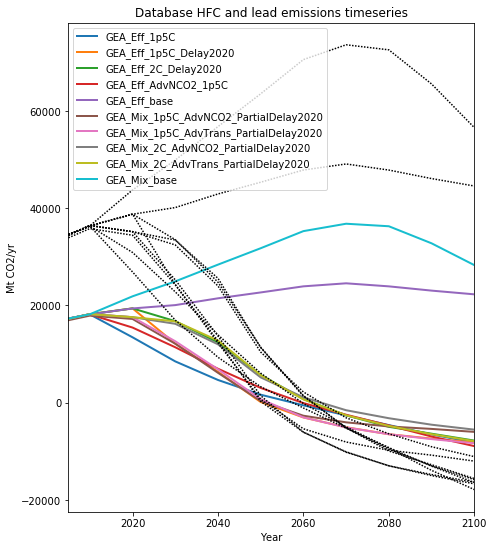

In [52]:
# NBVAL_IGNORE_OUTPUT
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
infilled.line_plot(ax=ax, **pkwargs)
to_infill.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(1, 1))
ax.set_title("Database HFC and lead emissions timeseries")


### SSP-specific relationship
This model pre-filters the data for only scenarios containing a specified string, which is generally supposed to represent an SSP model or other identifying feature. It then uses the Rolling Window Quantile cruncher as its workhorse. 

In [53]:
print(silicone.database_crunchers.DatabaseCruncherTimeDepRatio.__doc__)


    Database cruncher which uses the 'time-dependent ratio' technique.

    This cruncher derives the relationship between two variables by simply assuming
    that the follower timeseries is equal to the lead timeseries multiplied by a
    time-dependent scaling factor. The scaling factor is the ratio of the
    follower variable to the lead variable. If the database contains many such pairs,
    the scaling factor is the ratio between the means of the values.

    Once the relationship is derived, the 'filler' function will infill following:

    .. math::
        E_f(t) = s(t) * E_l(t)

    where :math:`E_f(t)` is emissions of the follower variable and :math:`E_l(t)` is
    emissions of the lead variable.

    :math:`s(t)` is the scaling factor, calculated as the ratio of the means of the
    the follower and the leader in the cruncher in the database.

    .. math::
        s(t) = \frac{mean( E_f(t) )}{mean( E_l(t) )})

    


We will use the Message database that contains many scenarios, but this method will only use ones corresponding to SSP2 in this exercise. 

In [54]:
sr15_data_ssp = sr15_data.copy().filter(
    model=["MESSAGE*"], 
    variable=["Emissions|CO2", "Emissions|VOC", "Emissions|CH4" ,"Emissions|HCF*"]
)
sr15_data_ssp.scenarios()

0                     ADVANCE_2020_1.5C-2100
1                         ADVANCE_2020_Med2C
2                          ADVANCE_2020_WB2C
3                         ADVANCE_2030_Med2C
4                     ADVANCE_2030_Price1.5C
5                          ADVANCE_2030_WB2C
6                               ADVANCE_INDC
7                           ADVANCE_NoPolicy
8                          ADVANCE_Reference
9                             CD-LINKS_INDCi
10                              CD-LINKS_NPi
11                     CD-LINKS_NPi2020_1000
12                     CD-LINKS_NPi2020_1600
13                      CD-LINKS_NPi2020_400
14                         CD-LINKS_NoPolicy
15                        EMF33_1.5C_cost100
16                           EMF33_1.5C_full
17                            EMF33_Baseline
18                       EMF33_Med2C_cost100
19                          EMF33_Med2C_full
20                        EMF33_Med2C_limbio
21                       EMF33_Med2C_nobeccs
22        

We will take data from the AIM database, but only corresponding to the SSP2 predictions

In [55]:
data_to_infill = sr15_data.copy().filter(
    model=["AIM*"], 
    scenario="SSP2*",
    variable=["Emissions|CO2", "Emissions|VOC", "Emissions|CH4" ,"Emissions|HCF*"], 
    year=sr15_data_ssp.data["year"].unique()
)
data_to_infill.scenarios()

0          SSP2-19
1          SSP2-26
2          SSP2-34
3          SSP2-45
4          SSP2-60
5    SSP2-Baseline
Name: scenario, dtype: object

 Although the lineshapes for CO2 (top two images below) look similar, the different models make different projections for the VOC (second row below).

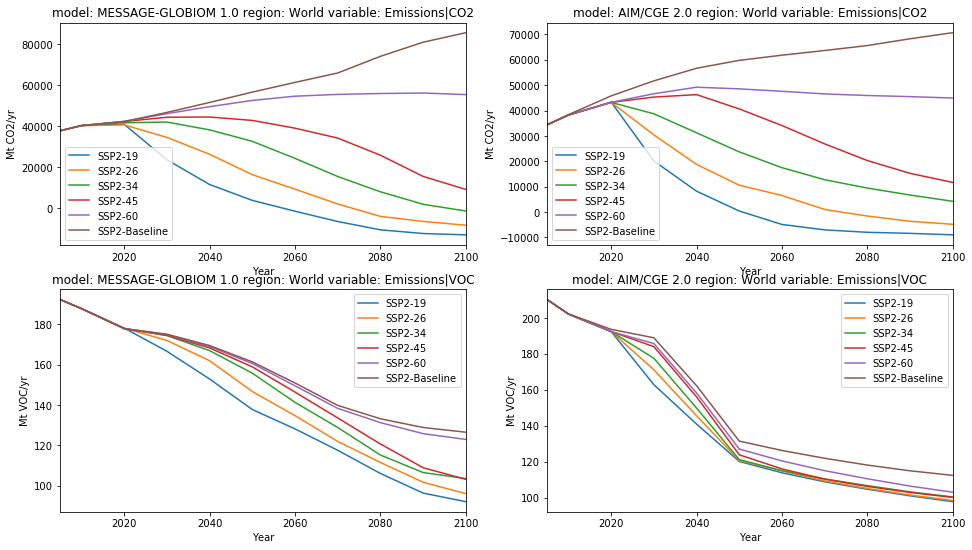

In [56]:
# NBVAL_IGNORE_OUTPUT
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(221)
sr15_data_ssp.filter(scenario="SSP2*", variable="*CO2").line_plot(ax=ax, color="scenario")
ax = fig.add_subplot(222)
data_to_infill.filter(scenario="SSP2*", variable="*CO2").line_plot(ax=ax, color="scenario")
ax = fig.add_subplot(223)
sr15_data_ssp.filter(scenario="SSP2*", variable="*VOC").line_plot(ax=ax, color="scenario")
ax = fig.add_subplot(224)
data_to_infill.filter(scenario="SSP2*", variable="*VOC").line_plot(ax=ax, color="scenario")

In [57]:
cruncher = silicone.database_crunchers.DatabaseCruncherSSPSpecificRelation(sr15_data_ssp)
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"], required_scenario="SSP2*")
infilled = filler(data_to_infill)

Infilling and investigating the trends, we see that the infilled results strongly resemble the portfolio of the infiller data. The original behaviour is presented on the right for comparison. This model does not allow results more extreme than the input values. 

Text(0.5, 1.0, 'VOC trends of infiller data')

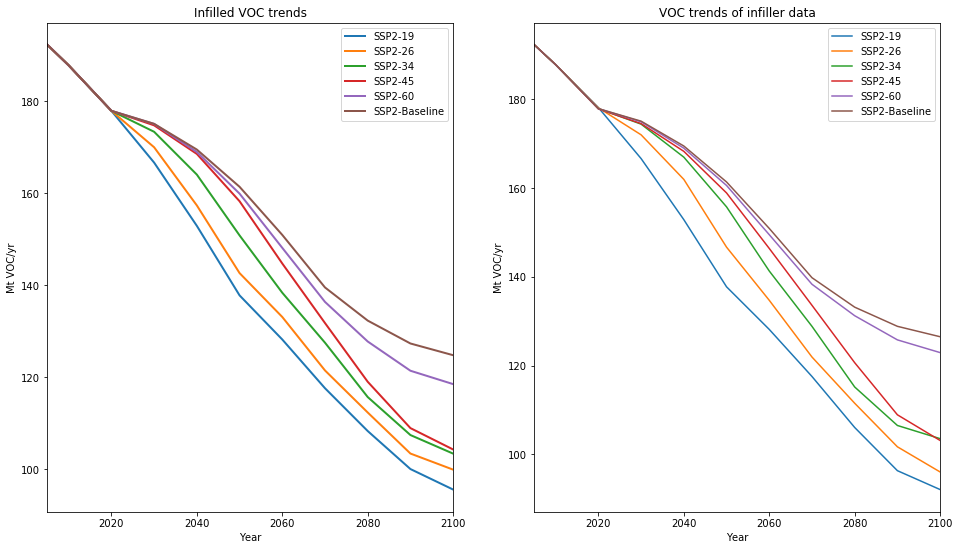

In [58]:
# NBVAL_IGNORE_OUTPUT
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
infilled.line_plot(ax=ax, **pkwargs)
ax.set_title("Infilled VOC trends")
ax = fig.add_subplot(122)
sr15_data_ssp.filter(scenario="SSP2*", variable="*VOC").line_plot(ax=ax, color="scenario")
ax.set_title("VOC trends of infiller data")



However, if we include data from many different models, the inter-model differences often exceed the differences within models, making for rather chaotic interpolation. This is shown below

In [59]:
scenario_string = "SSP2*"
too_much_data = sr15_data.copy().filter(variable=["Emissions|CO2", "Emissions|VOC", "Emissions|CH4" ,"Emissions|HCF*"])\
.filter( model=["AIM*"], keep=False)
cruncher = silicone.database_crunchers.DatabaseCruncherSSPSpecificRelation(too_much_data)
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"], required_scenario=scenario_string)
infilled = filler(data_to_infill)
wide_db = cruncher._make_wide_db(too_much_data.filter(scenario=scenario_string))
interpolator = cruncher._make_interpolator("Emissions|VOC", ["Emissions|CO2"], wide_db, "year")
interp_trendline = interpolator[2060](np.arange(-60000, 150000))

There is no simple function relating the CO2 and VOC trends in this case

Text(0.5, 1.0, 'VOC vs CO2 in 2060')

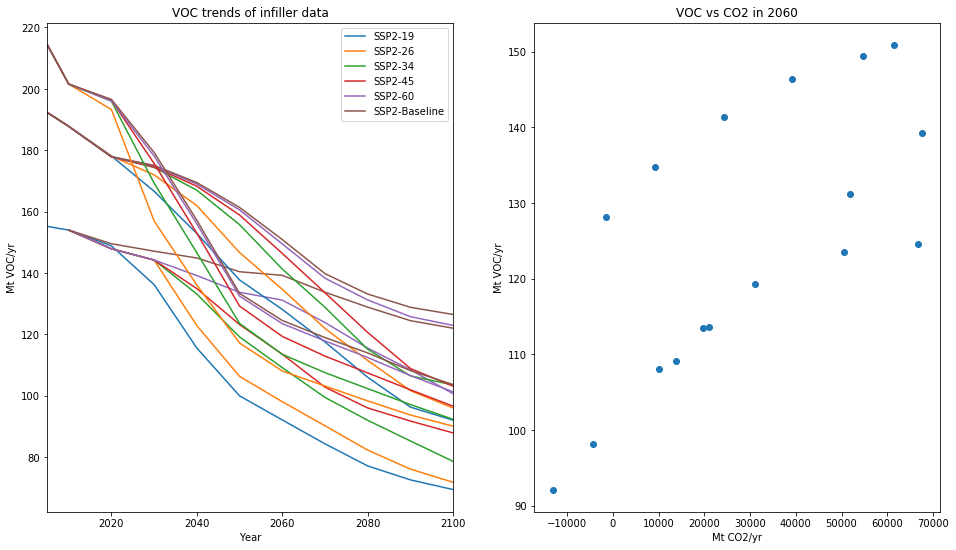

In [60]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
too_much_data.filter(scenario=scenario_string, variable="*VOC").line_plot(ax=ax, color="scenario")
ax.set_title("VOC trends of infiller data")
ax = fig.add_subplot(122)
plt.scatter(wide_db["Emissions|CO2"].loc[wide_db.index.get_level_values('year')==2060], 
         wide_db["Emissions|VOC"].loc[wide_db.index.get_level_values('year')==2060])
plt.xlabel("Mt CO2/yr")
plt.ylabel("Mt VOC/yr")
ax.set_title("VOC vs CO2 in 2060")

This means that we have uneven and non-monotonic trends in the output

Text(0, 0.5, 'Mt VOC/yr')

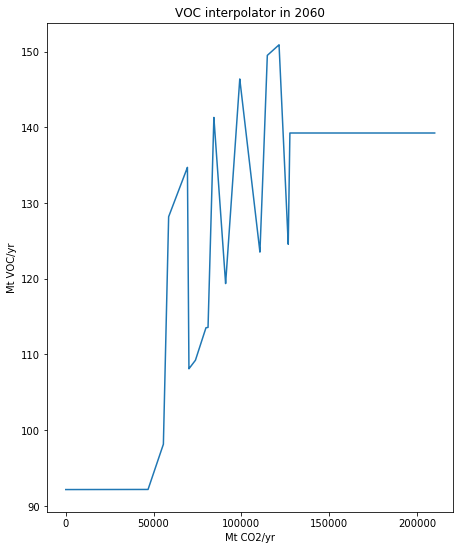

In [61]:
# NBVAL_IGNORE_OUTPUT
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
plt.plot(interp_trendline)
plt.title("VOC interpolator in 2060")
plt.xlabel("Mt CO2/yr")
plt.ylabel("Mt VOC/yr")

Text(0.5, 1.0, 'VOC trends of infiller data')

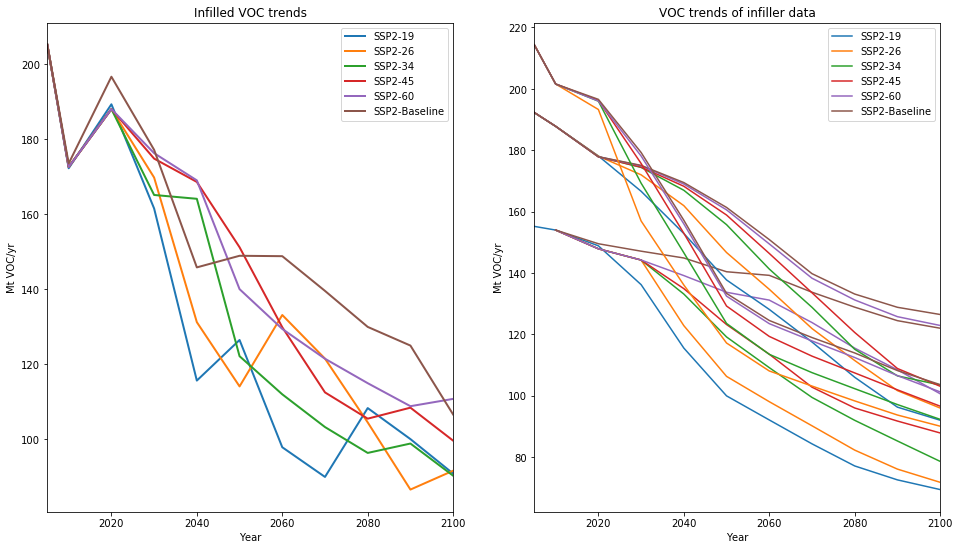

In [62]:
# NBVAL_IGNORE_OUTPUT
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
infilled.line_plot(ax=ax, **pkwargs)
ax.set_title("Infilled VOC trends")
ax = fig.add_subplot(122)
too_much_data.filter(scenario="SSP2*", variable="*VOC").line_plot(ax=ax, color="scenario")
ax.set_title("VOC trends of infiller data")

This package also has a function for detecting which of a group of scenarios creates an interpolation that best matches a dataset. Using this tool, we see that the CO2-CH4 relations in some SSP2 scenarios in the AIM database (data_to_infill) are more similar to SSP3 data from MESSAGE models (the sr15_data_ssp collection). 

In [63]:
cruncher = silicone.database_crunchers.DatabaseCruncherSSPSpecificRelation(sr15_data_ssp)
data_to_classify_19 = data_to_infill.filter(scenario="SSP2-Baseline")
possible_ssps = ["SSP1*", "SSP2*", "SSP3*"]
cruncher._find_matching_scenarios(data_to_classify_19, "Emissions|CH4", ["Emissions|CO2"], possible_ssps)

'SSP3*'

In [64]:
cruncher = silicone.database_crunchers.DatabaseCruncherSSPSpecificRelation(sr15_data_ssp)
data_to_classify_60 = data_to_infill.filter(scenario="SSP2-60")
possible_ssps = ["SSP1*", "SSP2*", "SSP3*"]
cruncher._find_matching_scenarios(data_to_classify_60, "Emissions|CH4", ["Emissions|CO2"], possible_ssps)

'SSP2*'

In [65]:
cruncher = silicone.database_crunchers.DatabaseCruncherSSPSpecificRelation(sr15_data_ssp)
data_to_classify_34 = data_to_infill.filter(scenario="SSP2-34")
possible_ssps = ["SSP1*", "SSP2*", "SSP3*"]
cruncher._find_matching_scenarios(data_to_classify_34, "Emissions|CH4", ["Emissions|CO2"], possible_ssps)

'SSP2*'